In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import os
# print(os.getcwd())

In [101]:

# --- Load CSV ---
csv_path = "../../results/merged_output_finished.csv"
df = pd.read_csv(csv_path) 

# --- Basic Cleanup ---
df.columns = df.columns.str.strip()

In [102]:
# Ensure correct dtypes
bool_cols = ["judge_answer_correctness_vs_ref", "judge_answer_helpfulness"]
for col in bool_cols:
    if df[col].dtype != bool:
        df[col] = df[col].astype(str).str.lower().isin(["true", "1", "yes"])

numeric_cols = ["meta_total_tokens", "cosine", "rougeL", "bleu"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [103]:

# --- Group and Aggregate ---
group_cols = ["approach", "model", "top_k"]

agg_df = (
    df.groupby(group_cols)
      .agg(
          avg_meta_total_tokens=("meta_total_tokens", "mean"),
          avg_cosine=("cosine", "mean"),
          avg_rougeL=("rougeL", "mean"),
          avg_bleu=("bleu", "mean"),
          true_correctness_count=("judge_answer_correctness_vs_ref", "sum"),
          total_correctness_count=("judge_answer_correctness_vs_ref", "count"),
          true_helpfulness_count=("judge_answer_helpfulness", "sum"),
          total_helpfulness_count=("judge_answer_helpfulness", "count")
      )
      .reset_index()
)

In [104]:
# Add percentage columns
agg_df["pct_correctness_true"] = (
    agg_df["true_correctness_count"] / agg_df["total_correctness_count"] * 100
)
agg_df["pct_helpfulness_true"] = (
    agg_df["true_helpfulness_count"] / agg_df["total_helpfulness_count"] * 100
)

In [105]:

# --- Summary ---
print("Summary of metrics by (approach, model, top_k):")
display(agg_df)

Summary of metrics by (approach, model, top_k):


,approach,model,top_k,avg_meta_total_tokens,avg_cosine,avg_rougeL,avg_bleu,true_correctness_count,total_correctness_count,true_helpfulness_count,total_helpfulness_count,pct_correctness_true,pct_helpfulness_true
0,graph_eager,gpt-5-mini-2025-08-07,3,2414.716667,0.306915,0.180248,0.048369,31,60,39,60,51.666667,65.000000
1,graph_eager,gpt-5-mini-2025-08-07,7,2419.816667,0.298157,0.186955,0.064791,32,60,41,60,53.333333,68.333333
2,graph_eager,gpt-5-nano-2025-08-07,3,2432.500000,0.297314,0.212039,0.066672,28,60,34,60,46.666667,56.666667
3,graph_eager,gpt-5-nano-2025-08-07,7,2443.050000,0.310916,0.211052,0.066526,29,60,34,60,48.333333,56.666667
4,graph_mmr,gpt-5-mini-2025-08-07,3,4146.933333,0.324127,0.189407,0.059842,39,60,44,60,65.000000,73.333333
5,graph_mmr,gpt-5-mini-2025-08-07,7,4164.966667,0.322273,0.184166,0.059939,42,60,43,60,70.000000,71.666667
6,graph_mmr,gpt-5-nano-2025-08-07,3,4180.566667,0.315583,0.216795,0.068156,35,60,41,60,58.333333,68.333333
7,graph_mmr,gpt-5-nano-2025-08-07,7,4169.150000,0.309635,0.220460,0.070648,33,60,41,60,55.000000,68.333333
8,lc_bm25,gpt-5-mini-2025-08-07,3,9846.500000,0.366665,0.213207,0.077585,46,60,49,60,76.666667,81.666667
9,lc_bm25,gpt-5-mini-2025-08-07,7,9854.783333,0.368714,0.192009,0.063715,45,60,50,60,75.000000,83.333333


In [106]:

# # --- Visualization Setup ---
# sns.set(style="whitegrid", palette="muted")

# # Function to plot bar charts for each metric
# def plot_metric(metric, title):
#     plt.figure(figsize=(10, 6))
#     sns.barplot(
#         data=agg_df,
#         x="top_k", y=metric,
#         hue="model"
#     )
#     plt.title(title)
#     plt.xlabel("top_k")
#     plt.ylabel(metric)
#     plt.legend(title="Model")
#     plt.tight_layout()
#     plt.show()

In [107]:

# # --- Plot metrics ---
# plot_metric("avg_cosine", "Average Cosine Similarity by Model/Top-K")
# plot_metric("avg_rougeL", "Average ROUGE-L by Model/Top-K")
# plot_metric("avg_bleu", "Average BLEU by Model/Top-K")
# plot_metric("avg_meta_total_tokens", "Average Total Tokens by Model/Top-K")
# plot_metric("pct_correctness_true", "% Correctness TRUE by Model/Top-K")
# plot_metric("pct_helpfulness_true", "% Helpfulness TRUE by Model/Top-K")


In [108]:

# --- Heatmap comparison ---
heatmap_df = (
    agg_df.groupby(["approach", "model"])
    [["avg_cosine", "avg_rougeL", "avg_bleu", "pct_correctness_true", "pct_helpfulness_true"]]
    .mean()
    .reset_index()
)

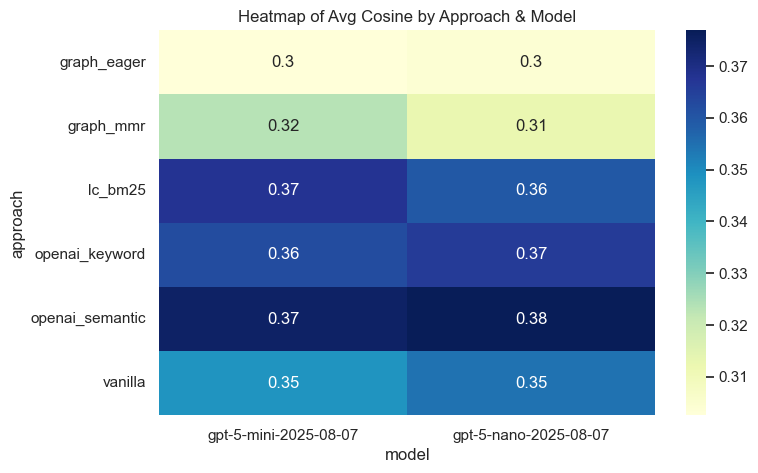

In [109]:

heatmap_df_pivot = heatmap_df.pivot(
    index="approach", 
    columns="model", 
    values="avg_cosine"
)
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df_pivot, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Avg Cosine by Approach & Model")
plt.show()

In [110]:
# =======================================
# Section 8: Evaluate Best Combinations
# =======================================

# Sort and display top combinations by correctness
best_correctness = agg_df.sort_values("pct_correctness_true", ascending=False)
best_helpfulness = agg_df.sort_values("pct_helpfulness_true", ascending=False)

print("\nTop combinations by % Correctness TRUE:")
display(best_correctness[[
    "approach", "model", "top_k", 
    "pct_correctness_true", "avg_cosine", "avg_rougeL", "avg_bleu"
]])

print("\nTop combinations by % Helpfulness TRUE:")
display(best_helpfulness[[
    "approach", "model", "top_k", 
    "pct_helpfulness_true", "avg_cosine", "avg_rougeL", "avg_bleu"
]])


Top combinations by % Correctness TRUE:


,approach,model,top_k,pct_correctness_true,avg_cosine,avg_rougeL,avg_bleu
13,openai_keyword,gpt-5-mini-2025-08-07,7,86.666667,0.361697,0.188480,0.057618
12,openai_keyword,gpt-5-mini-2025-08-07,3,83.333333,0.362981,0.203452,0.067041
17,openai_semantic,gpt-5-mini-2025-08-07,7,83.333333,0.369856,0.203863,0.075078
16,openai_semantic,gpt-5-mini-2025-08-07,3,81.666667,0.379911,0.218118,0.079534
21,vanilla,gpt-5-mini-2025-08-07,7,78.333333,0.360256,0.194056,0.065420
18,openai_semantic,gpt-5-nano-2025-08-07,3,76.666667,0.376737,0.263464,0.109651
8,lc_bm25,gpt-5-mini-2025-08-07,3,76.666667,0.366665,0.213207,0.077585
9,lc_bm25,gpt-5-mini-2025-08-07,7,75.000000,0.368714,0.192009,0.063715
15,openai_keyword,gpt-5-nano-2025-08-07,7,73.333333,0.366657,0.234396,0.077591
5,graph_mmr,gpt-5-mini-2025-08-07,7,70.000000,0.322273,0.184166,0.059939



Top combinations by % Helpfulness TRUE:


,approach,model,top_k,pct_helpfulness_true,avg_cosine,avg_rougeL,avg_bleu
21,vanilla,gpt-5-mini-2025-08-07,7,90.000000,0.360256,0.194056,0.065420
16,openai_semantic,gpt-5-mini-2025-08-07,3,90.000000,0.379911,0.218118,0.079534
19,openai_semantic,gpt-5-nano-2025-08-07,7,90.000000,0.377108,0.240732,0.085257
13,openai_keyword,gpt-5-mini-2025-08-07,7,88.333333,0.361697,0.188480,0.057618
17,openai_semantic,gpt-5-mini-2025-08-07,7,88.333333,0.369856,0.203863,0.075078
15,openai_keyword,gpt-5-nano-2025-08-07,7,86.666667,0.366657,0.234396,0.077591
14,openai_keyword,gpt-5-nano-2025-08-07,3,85.000000,0.365223,0.246771,0.078226
9,lc_bm25,gpt-5-mini-2025-08-07,7,83.333333,0.368714,0.192009,0.063715
18,openai_semantic,gpt-5-nano-2025-08-07,3,83.333333,0.376737,0.263464,0.109651
12,openai_keyword,gpt-5-mini-2025-08-07,3,81.666667,0.362981,0.203452,0.067041


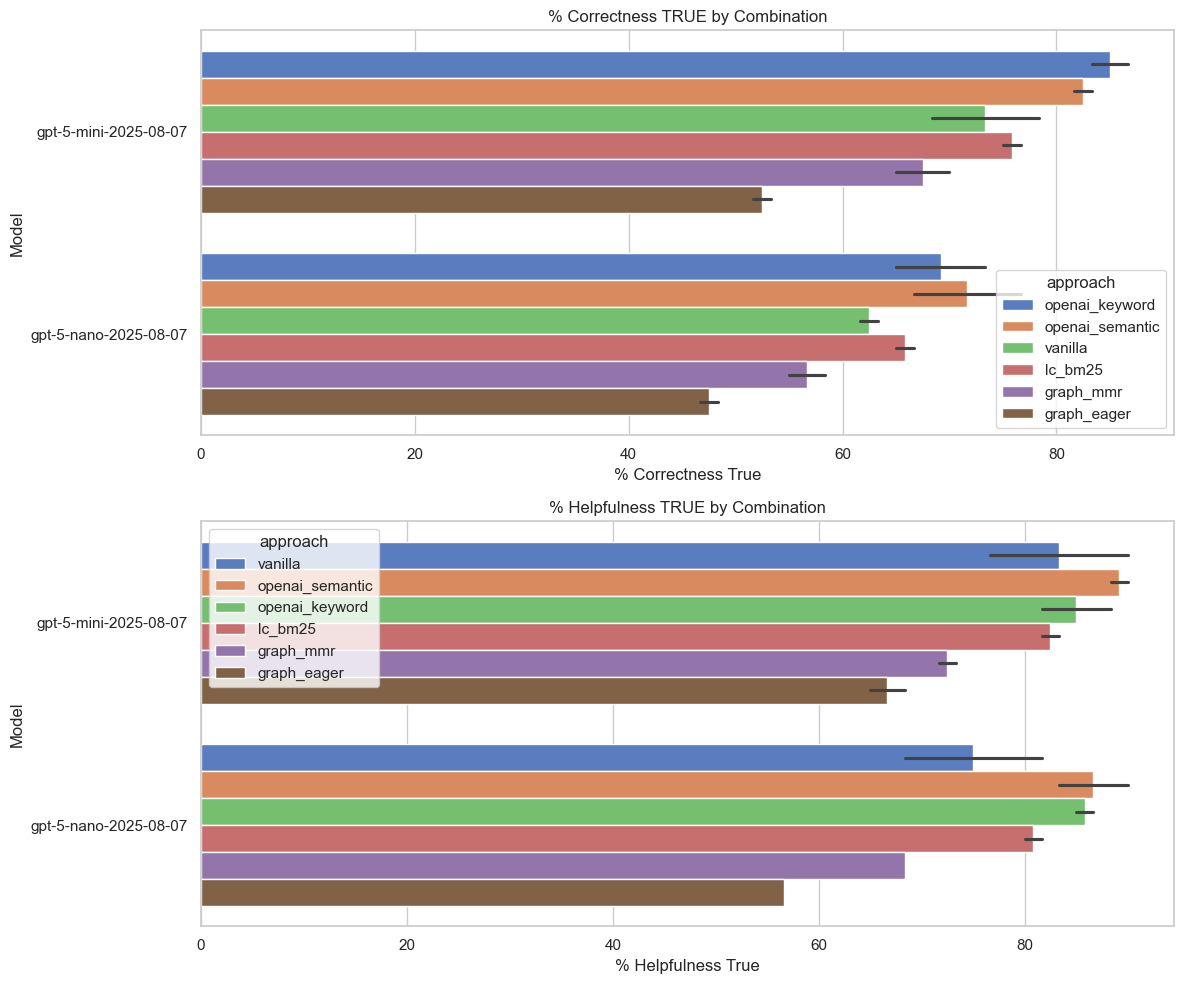

In [111]:
# =======================================
# Visual Comparison Bar Charts
# =======================================

# Combine metrics in one figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(
    data=agg_df.sort_values("pct_correctness_true", ascending=False),
    x="pct_correctness_true", 
    y="model", 
    hue="approach", 
    ax=axes[0]
)
axes[0].set_title("% Correctness TRUE by Combination")
axes[0].set_xlabel("% Correctness True")
axes[0].set_ylabel("Model")

sns.barplot(
    data=agg_df.sort_values("pct_helpfulness_true", ascending=False),
    x="pct_helpfulness_true", 
    y="model", 
    hue="approach", 
    ax=axes[1]
)
axes[1].set_title("% Helpfulness TRUE by Combination")
axes[1].set_xlabel("% Helpfulness True")
axes[1].set_ylabel("Model")

plt.tight_layout()
plt.show()

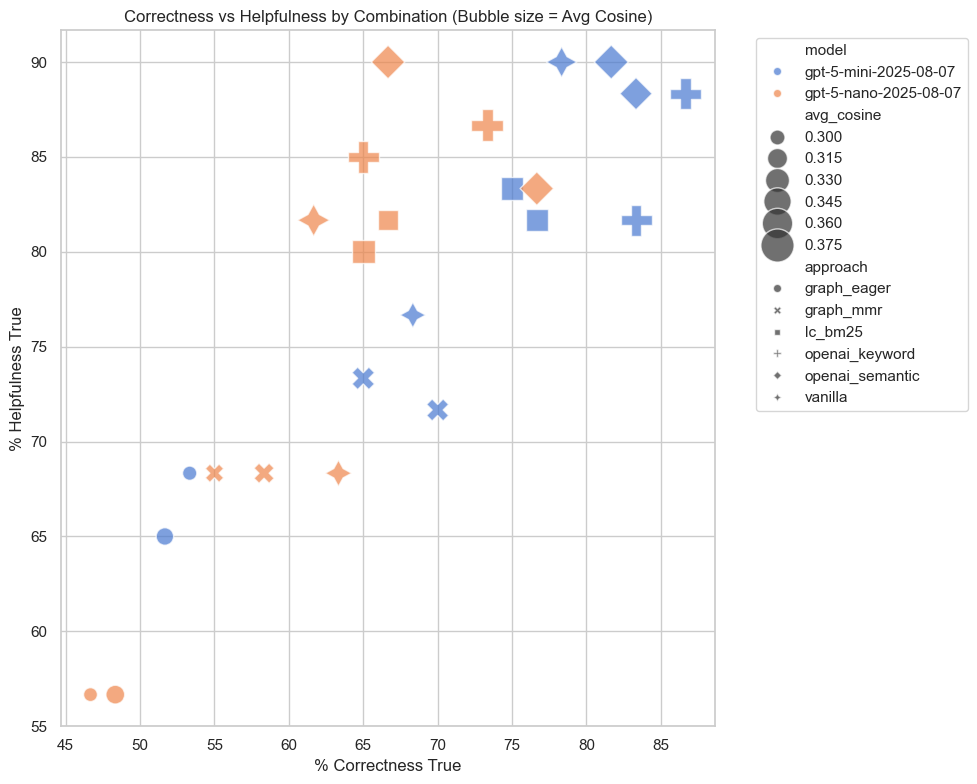

In [112]:
# =======================================
# Annotated Bubble Chart
# =======================================

# Bubble chart: each combination plotted by correctness vs helpfulness
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    data=agg_df,
    x="pct_correctness_true",
    y="pct_helpfulness_true",
    size="avg_cosine",
    hue="model",
    style="approach",
    sizes=(100, 600),
    alpha=0.7
)
plt.title("Correctness vs Helpfulness by Combination (Bubble size = Avg Cosine)")
plt.xlabel("% Correctness True")
plt.ylabel("% Helpfulness True")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

# =======================================
# Combined Scoring View
# =======================================

# Create a composite ranking score (normalized 0–1)
from sklearn.preprocessing import MinMaxScaler # type: ignore

scaler = MinMaxScaler()
agg_df[["score_correctness", "score_helpfulness"]] = scaler.fit_transform(
    agg_df[["pct_correctness_true", "pct_helpfulness_true"]]
)
agg_df["combined_score"] = (agg_df["score_correctness"] + agg_df["score_helpfulness"]) / 2

ranked = agg_df.sort_values("combined_score", ascending=False)
ranked["rank"] = 0

for idx, (i,row) in enumerate(ranked.iterrows()):
    ranked.loc[i, "rank"] = idx
print("\nRanked by Combined Correctness+Helpfulness Score:")
display(ranked[[
    "rank", "approach", "model", "top_k", 
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]])


Ranked by Combined Correctness+Helpfulness Score:


,rank,approach,model,top_k,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,86.666667,88.333333,0.975000
16,1,openai_semantic,gpt-5-mini-2025-08-07,3,81.666667,90.000000,0.937500
17,2,openai_semantic,gpt-5-mini-2025-08-07,7,83.333333,88.333333,0.933333
21,3,vanilla,gpt-5-mini-2025-08-07,7,78.333333,90.000000,0.895833
12,4,openai_keyword,gpt-5-mini-2025-08-07,3,83.333333,81.666667,0.833333
15,5,openai_keyword,gpt-5-nano-2025-08-07,7,73.333333,86.666667,0.783333
18,6,openai_semantic,gpt-5-nano-2025-08-07,3,76.666667,83.333333,0.775000
9,7,lc_bm25,gpt-5-mini-2025-08-07,7,75.000000,83.333333,0.754167
8,8,lc_bm25,gpt-5-mini-2025-08-07,3,76.666667,81.666667,0.750000
19,9,openai_semantic,gpt-5-nano-2025-08-07,7,66.666667,90.000000,0.750000


In [123]:
display(ranked[[
    "rank", "approach", "model", "top_k", 
    "pct_correctness_true", "pct_helpfulness_true", "combined_score"
]].head(5))

,rank,approach,model,top_k,pct_correctness_true,pct_helpfulness_true,combined_score
13,0,openai_keyword,gpt-5-mini-2025-08-07,7,86.666667,88.333333,0.975000
16,1,openai_semantic,gpt-5-mini-2025-08-07,3,81.666667,90.000000,0.937500
17,2,openai_semantic,gpt-5-mini-2025-08-07,7,83.333333,88.333333,0.933333
21,3,vanilla,gpt-5-mini-2025-08-07,7,78.333333,90.000000,0.895833
12,4,openai_keyword,gpt-5-mini-2025-08-07,3,83.333333,81.666667,0.833333
